In [39]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when, count, isnan, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime


In [40]:
def create_spark_session():
    return SparkSession.builder \
        .appName("EmployeeAttritionAnalysis") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

spark = create_spark_session()


24/11/22 01:14:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [41]:
def load_and_explore_data(spark, file_path):
    data = spark.read.csv(file_path, header=True, inferSchema=True)
    print("Dataset Schema:")
    data.printSchema()
    print(f"\nTotal Records: {data.count()}")
    print("\nMissing Values Count:")
    for column in data.columns:
        null_count = data.filter(col(column).isNull() | isnan(col(column))).count()
        print(f"{column}: {null_count}")
    return data

file_path = "hdfs://localhost:9000/user/bigdata_proj/Employee-Attrition.csv"
data = load_and_explore_data(spark, file_path)


Dataset Schema:
root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- O

In [42]:
def preprocess_data(data):
    data = data.na.fill({'JobSatisfaction': 3, 'WorkLifeBalance': 3})

    categorical_cols = ['Gender', 'JobRole', 'Department', 'BusinessTravel']
    numeric_cols = ['MonthlyIncome', 'YearsAtCompany']

    indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols]

    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
    scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")

    feature_assembler = VectorAssembler(
        inputCols=[col + "_encoded" for col in categorical_cols] + ["scaled_numeric_features"],
        outputCol="features"
    )

    stages = indexers + encoders + [assembler, scaler, feature_assembler]
    pipeline = Pipeline(stages=stages)
    processed_data = pipeline.fit(data).transform(data)

    return processed_data

processed_data = preprocess_data(data)

indexer = StringIndexer(inputCol='Attrition', outputCol='Attrition_Label')
processed_data = indexer.fit(processed_data).transform(processed_data)


In [43]:
train_data, test_data = processed_data.randomSplit([0.8, 0.2], seed=42)

def train_logistic_regression(train_data):
    lr = LogisticRegression(labelCol="Attrition_Label", featuresCol="features")
    lr_model = lr.fit(train_data)
    return lr_model

def train_gbt(train_data):
    gbt = GBTClassifier(labelCol="Attrition_Label", featuresCol="features", maxIter=10)
    gbt_model = gbt.fit(train_data)
    return gbt_model

lr_model = train_logistic_regression(train_data)
gbt_model = train_gbt(train_data)



In [44]:
def calculate_detailed_metrics(predictions, model_name):
    pred_df = predictions.select(['prediction', 'Attrition_Label']).toPandas()
    TP = ((pred_df['prediction'] == 1) & (pred_df['Attrition_Label'] == 1)).sum()
    TN = ((pred_df['prediction'] == 0) & (pred_df['Attrition_Label'] == 0)).sum()
    FP = ((pred_df['prediction'] == 1) & (pred_df['Attrition_Label'] == 0)).sum()
    FN = ((pred_df['prediction'] == 0) & (pred_df['Attrition_Label'] == 1)).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

lr_predictions = lr_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)
lr_metrics = calculate_detailed_metrics(lr_predictions, "Logistic Regression")
gbt_metrics = calculate_detailed_metrics(gbt_predictions, "Gradient Boosted Tree")




Logistic Regression Metrics:
Accuracy: 0.8386
Precision: 1.0000
Recall: 0.0889
F1 Score: 0.1633

Gradient Boosted Tree Metrics:
Accuracy: 0.8228
Precision: 0.5000
Recall: 0.2000
F1 Score: 0.2857


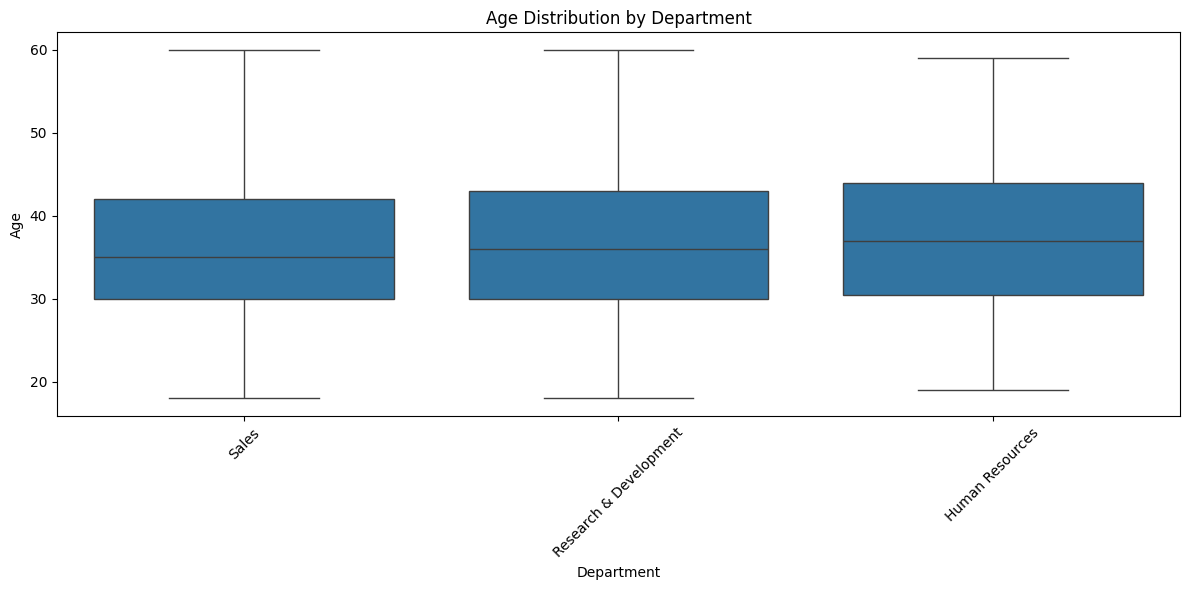

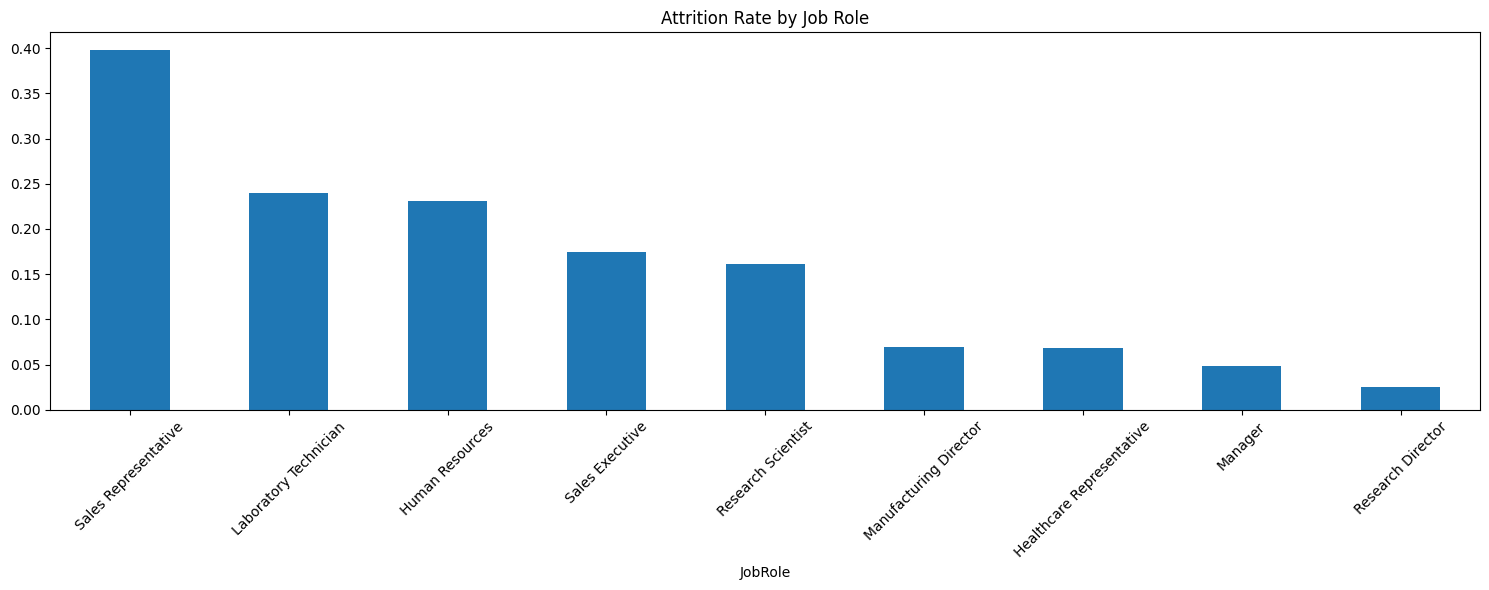

In [45]:
def create_additional_visualizations(data):
    pandas_df = data.toPandas()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Department', y='Age', data=pandas_df)
    plt.title('Age Distribution by Department')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    attrition_by_role = pandas_df.groupby('JobRole')['Attrition'].apply(
        lambda x: (x == 'Yes').mean()
    ).sort_values(ascending=False)

    plt.figure(figsize=(15, 6))
    attrition_by_role.plot(kind='bar')
    plt.title('Attrition Rate by Job Role')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

create_additional_visualizations(processed_data)


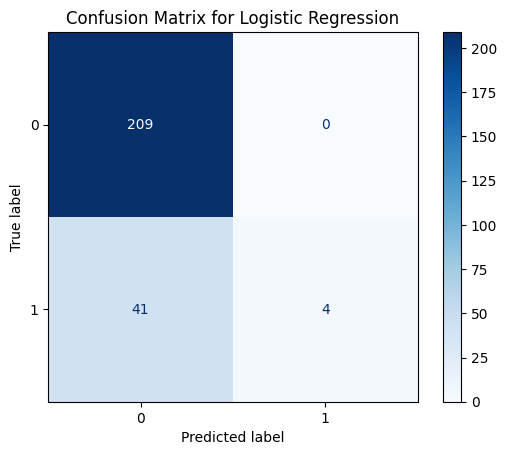

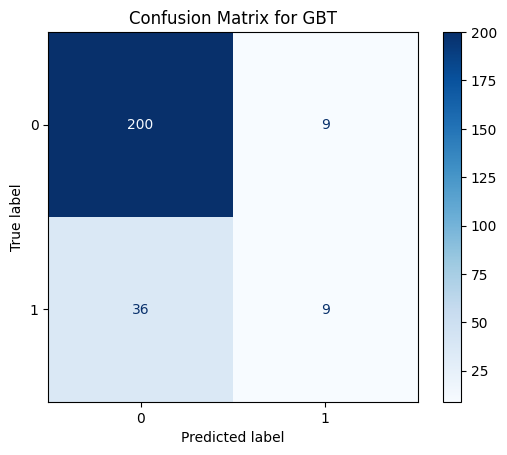

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Label")

lr_preds = lr_predictions.select("prediction", "Attrition_Label").toPandas()
lr_cm = confusion_matrix(lr_preds["Attrition_Label"], lr_preds["prediction"])

ConfusionMatrixDisplay(lr_cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

gbt_preds = gbt_predictions.select("prediction", "Attrition_Label").toPandas()
gbt_cm = confusion_matrix(gbt_preds["Attrition_Label"], gbt_preds["prediction"])

ConfusionMatrixDisplay(gbt_cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for GBT')
plt.show()



Logistic Regression ROC AUC: 0.655077086656034
GBT ROC AUC: 0.6428495481127054


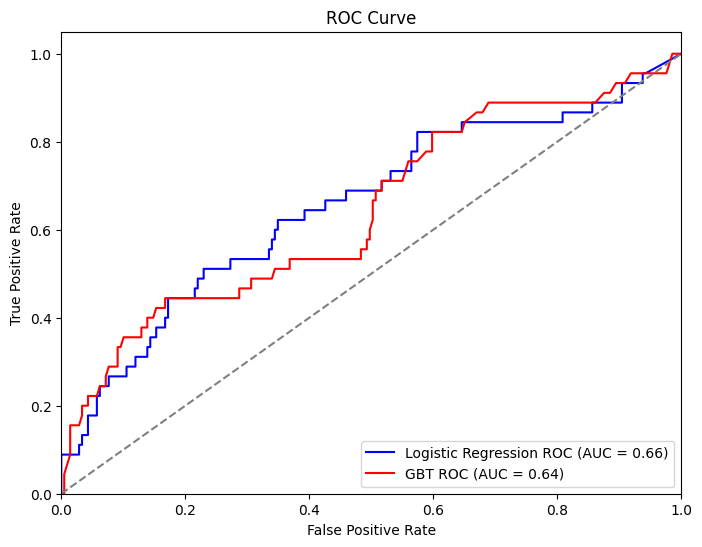

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F
from sklearn.metrics import roc_curve, auc
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Attrition_Label")

lr_roc = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderROC"})
gbt_roc = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})

print(f"Logistic Regression ROC AUC: {lr_roc}")
print(f"GBT ROC AUC: {gbt_roc}")
lr_fpr, lr_tpr, _ = roc_curve(lr_predictions.select("Attrition_Label").collect(), 
                               lr_predictions.select("probability").rdd.map(lambda x: x[0][1]).collect())
gbt_fpr, gbt_tpr, _ = roc_curve(gbt_predictions.select("Attrition_Label").collect(), 
                                 gbt_predictions.select("probability").rdd.map(lambda x: x[0][1]).collect())

# Plotting the ROC curve
plt.figure(figsize=(8,6))
plt.plot(lr_fpr, lr_tpr, color='blue', label=f'Logistic Regression ROC (AUC = {lr_roc:.2f})')
plt.plot(gbt_fpr, gbt_tpr, color='red', label=f'GBT ROC (AUC = {gbt_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [48]:
def create_summary_report(lr_metrics, gbt_metrics):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open('attrition_analysis_report.txt', 'w') as f:
        f.write(f"Employee Attrition Analysis Report\n")
        f.write(f"Generated on: {timestamp}\n")
        f.write("\n" + "="*50 + "\n")

        f.write("\nLogistic Regression Metrics:\n")
        f.write(f"Accuracy: {lr_metrics[0]:.4f}\n")
        f.write(f"Precision: {lr_metrics[1]:.4f}\n")
        f.write(f"Recall: {lr_metrics[2]:.4f}\n")
        f.write(f"F1 Score: {lr_metrics[3]:.4f}\n")

        f.write("\nGradient Boosting Metrics:\n")
        f.write(f"Accuracy: {gbt_metrics[0]:.4f}\n")
        f.write(f"Precision: {gbt_metrics[1]:.4f}\n")
        f.write(f"Recall: {gbt_metrics[2]:.4f}\n")
        f.write(f"F1 Score: {gbt_metrics[3]:.4f}\n")

create_summary_report(lr_metrics, gbt_metrics)
spark.stop()
